# Robbing the Fed: Directly Obtaining Private Data in Federated Learning with Modified Models

This notebook shows an example for the threat model and attack described in "Robbing the Fed: Directly Obtaining Private Data in Federated Learning with Modified Models". This example deviates from the other "honest-but-curious" server models and investigates an actively malicious model. As such, the attack applies to any model architecture, but its impact is more or less obvious (or not at all) depending on the already present architecture onto which the malicious "Imprint" block is grafted.

In this notebook, we place the block in front of a ResNet18, as an example. The attack can also be conceptualized as merely a "malicious parameters" attack against a model which contains, for example, only fully connected layers or only convolutions without strides and fully connected layers.


Paper URL: https://openreview.net/forum?id=fwzUgo0FM9v

This variation implements the **one shot attack** shown in Fig. 3 of the paper. We aggregate **32'768** data points here, but this number is only limited by the amount of time you are willing to wait for the aggregated gradients to be computed (Aside from numerical issues which are likely to appear at astronomical batch sizes). 

The expected number of cases in which this attacks recovers a unique data point *is always 1/e ≈ 37%*. As such please also do not be surprised when repeating the steps in this notebook does not work the very first time.

Note:
   * This example requires access to the entire ImageNet training set.

### Startup

In [1]:
try:
    import breaching
except ModuleNotFoundError:
    # You only really need this safety net if you want to run these notebooks directly in the examples directory
    # Don't worry about this if you installed the package or moved the notebook to the main directory.
    import os; os.chdir("..")
    import breaching
    
import torch
%load_ext autoreload
%autoreload 2

# Redirects logs directly into the jupyter notebook
import logging, sys
logging.basicConfig(level=logging.INFO, handlers=[logging.StreamHandler(sys.stdout)], format='%(message)s')
logger = logging.getLogger()

### Initialize cfg object and system setup:

This will load the full configuration object. This includes the configuration for the use case and threat model as `cfg.case` and the hyperparameters and implementation of the attack as `cfg.attack`. All parameters can be modified below, or overriden with `overrides=` as if they were cmd-line arguments.

In [2]:
cfg = breaching.get_config(overrides=["attack=imprint", "case=8_industry_scale_fl", 
                                      "case/server=malicious-model-rtf"])
          
device = torch.device(f'cuda') if torch.cuda.is_available() else torch.device('cpu')
torch.backends.cudnn.benchmark = cfg.case.impl.benchmark
setup = dict(device=device, dtype=getattr(torch, cfg.case.impl.dtype))
setup

Investigating use case industry_scale_fl with server type malicious_model.


{'device': device(type='cuda'), 'dtype': torch.float32}

### Modify config options here

You can use `.attribute` access to modify any of these configurations for the attack, or the case:

In [3]:
users = 128 # We aggregate over this number of users
cfg.case.user.user_range = [0, users]
cfg.case.user.num_data_points = 256 # How many data points per user

cfg.case.data.examples_from_split = 'training' # We have to draw images from the ImageNet training set
cfg.case.data.default_clients = users
cfg.case.data.partition = "random"

cfg.case.server.model_modification.type = 'OneShotBlock'
cfg.case.server.model_modification.num_bins = cfg.case.user.num_data_points * users # These are "virtual" bins
# Only two bins are actually created for the attack

In [4]:
cfg.attack.breach_padding = False # This would not fit into the GPU memory

In [5]:
# How does the block interact with the model?
# The block can be placed later in the model given a position such as  '4.0.conv':
cfg.case.server.model_modification.position = None  # None defaults to the first layer
# The block can also be connected in various ways to the other layers:
cfg.case.server.model_modification.connection = 'addition'

cfg.case.server.model_modification.linfunc = 'fourier' 
cfg.case.server.model_modification.mode = 32

### Instantiate all parties

The following lines generate "server, "user" and "attacker" objects and print an overview of their configurations.
In this example, the "user" is actually a `MultiUserAggregate` object that behaves like a single user, but aggregates a larger number of users. The server only interfaces with the `MultiUserAggregate` and has no access its users.

In [6]:
user, server, model, loss_fn = breaching.cases.construct_case(cfg.case, setup)
attacker = breaching.attacks.prepare_attack(server.model, server.loss, cfg.attack, setup)
breaching.utils.overview(server, user, attacker)

First layer determined to be model.conv1
Block inserted at feature shape torch.Size([3, 224, 224]).
Model architecture ResNet18 loaded with 11,681,231 parameters and 9,620 buffers.
Overall this is a data ratio of       0:1 for target shape [256, 3, 224, 224] given that num_queries=1.
User (of type UserSingleStep) with settings:
    Number of data points: 256

    Threat model:
    User provides labels: False
    User provides buffers: False
    User provides number of data points: True

    Data:
    Dataset: ImageNetAnimals
    user: 0
    
        
    Number of aggregated users: 128
Server (of type MaliciousModelServer) with settings:
    Threat model: Malicious (Analyst)
    Number of planned queries: 1
    Has external/public data: False

    Model:
        model specification: ResNet18
        model state: default
        public buffers: True

    Secrets: {'ImprintBlock': {'weight_idx': 0, 'bias_idx': 1, 'shape': torch.Size([3, 224, 224]), 'structure': 'cumulative'}}
    
Attack

### Simulate an attacked FL protocol

This exchange is a simulation of a single query in a federated learning protocol. The server sends out a `server_payload` and the user computes an update based on their private local data. This user update is `shared_data` and contains, for example, the parameter gradient of the model in the simplest case. `true_user_data` is also returned by `.compute_local_updates`, but of course not forwarded to the server or attacker and only used for (our) analysis.

In [7]:
server_payload = server.distribute_payload()
shared_data, _ = user.compute_local_updates(server_payload)  

Computing user update in model mode: eval.
Computing user update in model mode: eval.
Computing user update in model mode: eval.
Computing user update in model mode: eval.
Computing user update in model mode: eval.
Computing user update in model mode: eval.
Computing user update in model mode: eval.
Computing user update in model mode: eval.
Computing user update in model mode: eval.
Computing user update in model mode: eval.
Computing user update in model mode: eval.
Computing user update in model mode: eval.
Computing user update in model mode: eval.
Computing user update in model mode: eval.
Computing user update in model mode: eval.
Computing user update in model mode: eval.
Computing user update in model mode: eval.
Computing user update in model mode: eval.
Computing user update in model mode: eval.
Computing user update in model mode: eval.
Computing user update in model mode: eval.
Computing user update in model mode: eval.
Computing user update in model mode: eval.
Computing u

In [8]:
# user.plot(true_user_data) # Not a great idea for this batch size

### Reconstruct user data:

Now we launch the attack, reconstructing user data based on only the `server_payload` and the `shared_data`. 

For this attack, we also share secret information from the malicious server with the attack (`server.secrets`), which here is the location and structure of the imprint block.

In [9]:
reconstructed_user_data, stats = attacker.reconstruct([server_payload], [shared_data], server.secrets, 
                                                      dryrun=cfg.dryrun)

Initially produced 2 hits.


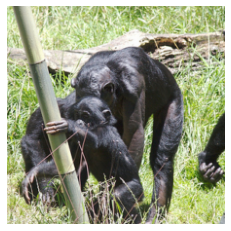

In [15]:
found_data = dict(data = reconstructed_user_data['data'][1:2], labels=None)
user.plot(found_data)

#### Identify which user image this is 

In [11]:
evaluated_data = 0
for idx, data in enumerate(user.dataloader):
    dists = (found_data['data'] - data["inputs"].to(**setup)).pow(2).mean(dim=[1, 2, 3])
    min_dist, match_idx = dists.min(dim=0)
    if min_dist < 0.1:
        break
    else:
        evaluated_data += len(dists)
    if evaluated_data % 1000 == 0:
        print(f'Currently at index {evaluated_data}')
    match_idx = dists.argmin()
print(f"Found match at index {match_idx}.")
matching_user_data = dict(data = data["inputs"][match_idx:match_idx+1].to(**setup), 
                          labels=data["labels"][match_idx:match_idx+1])

Found match at index 123.


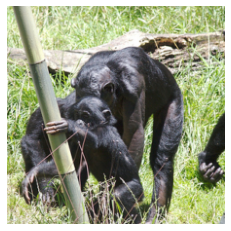

In [12]:
user.plot(matching_user_data)

This saves a lot of compute as we can now compute metrics for the matching data point only:

In [13]:
metrics = breaching.analysis.report(found_data, matching_user_data, [server_payload], 
                                    server.model, order_batch=True, compute_full_iip=False, 
                                    cfg_case=cfg.case, setup=setup)

METRICS: | MSE: 0.0000 | PSNR: 47.08 | FMSE: 6.2075e-02 | LPIPS: 0.00|
 R-PSNR: 47.08 | IIP-pixel: 100.00% | SSIM: 0.9997 | max R-PSNR: 47.08 | max SSIM: 0.9997 | Label Acc: 0.00%


### Notes:
* The attack always produces two hits, the first of which is the average of all data which has a lower measure than the measured bin, and the second of which is the singled-out target datapoint.
* Any PSNR score bigger than 80 is essentially meaninglessly good and will for a given image lie between 80 and 180 based on numerical issues.
* We start to see minor numerical degradations here, for a batch size of 32'768. However the same degradations would also apply to the gradient update itself - accumulating this much data has the same (numerical) impact on the actual model training as it has on the attack.
* This attack recovers no label by itself, but it could be predicted from the trained model.
*  `OneShotBlockSparse` is also an option, which has only half as many parameters, but requires a HardTanh to be constructed over two layers.